In [2]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (6,3)

## Hormone data

In [3]:
df = pd.read_csv('horm_sort.csv', usecols = [0,1,2,3])
df[['Testosterone']]= df[['Testosterone']].apply(pd.to_numeric, errors='coerce')
df.rename(columns={"Subjects": "ID"}, inplace = True)
h_df = df.groupby(['Time','Type','ID'])['Testosterone'].min().unstack().T
h_df.columns = ['Pl_T0','T_T0','Pl_T1','T_T1']
h_df.loc['MR24','Pl_T0'] = h_df.loc['MR24','Pl_T1'] 
h_df.loc['MR25','T_T1'] = h_df[h_df['Pl_T0'].between(18, 25)]['T_T1'].mean()
h_df['Pl_change'] = (h_df['Pl_T1']-h_df['Pl_T0'])/h_df['Pl_T0']
h_df['T_change'] = (h_df['T_T1']-h_df['T_T0'])/h_df['T_T0']
h_df['TPl_change'] = (h_df['T_T1']-h_df['Pl_T1'])/h_df['Pl_T1']
TPl_change = h_df.TPl_change
TPl_change['MR23'] = TPl_change.mean()
#TPl_change
ids = pd.read_excel('EE_subj_list.xlsx', header=None, usecols = [1,2])
ids.columns = ['ID', 'Subjects']
ids = ids.join(TPl_change, on = ['ID'])


,ID,Subjects,TPl_change
0,MR01,Subj1,2.655172
1,MR02,Subj2,0.491713
2,MR03,Subj3,1.287879
3,MR04,Subj4,0.030303
4,MR05,Subj5,0.416894
5,MR06,Subj6,0.638710
6,MR07,Subj7,0.780822
7,MR08,Subj8,0.525000
8,MR09,Subj9,0.975490
9,MR10,Subj10,0.067511


## Endowment data

In [7]:
df = pd.read_excel('MeMi_Endowment_list.xlsx')
df1 = pd.melt(df, id_vars=['Subjects','Item','Type','Market Price'], value_vars=['WTA_Test','WTA_Plac'], value_name='WTA')
df1['Test'] = 0
df1.loc[df1.variable.str.contains('Test'),'Test'] = 1
df1.drop('variable', axis=1, inplace = True)
df2 = pd.melt(df, id_vars=['Subjects','Item','Type','Market Price'], value_vars=['WTP_Test','WTP_Plac'], value_name='WTP')
df2['Test'] = 0
df2.loc[df2.variable.str.contains('Test'),'Test'] = 1
df2.drop('variable', axis=1, inplace = True)
df = df1.merge(df2)
df.drop(df.index[(df.WTA.isin([0, np.nan])) | (df.WTP.isin([0, np.nan]))], inplace = True)
df['WTA/WTP'] = df.WTA/df.WTP
df = pd.merge(df, ids, on = 'Subjects')
df.loc[df.Test==0, 'TPl_change'] = 0
df = df.drop(['Market Price','WTA','WTP','ID'],axis=1)

Change outliers to max value

In [8]:
max_rel = df['WTA/WTP'].mean()+3*df['WTA/WTP'].std()
df['WTAPcorr'] = df['WTA/WTP']
df.loc[df['WTA/WTP']>max_rel,'WTAPcorr'] = max_rel


In [9]:
df["ItemCodes"] = pd.Categorical(df['Item']).codes
df["SubjectsCode"] = pd.Categorical(df['Subjects']).codes

In [10]:
#df.groupby(['Type','Item','ItemCodes','Test'])['WTA/WTP','WTAPcorr'].mean()

In [11]:
with pm.Model() as model_0:  
    a_item  = pm.Normal('a_item', mu = 1, sd = 2, shape = 27)
    sigma = pm.HalfCauchy('sigma', beta = 1, shape = 27)
    mu = pm.Deterministic('mu', a_item[df.ItemCodes.values])
    
    WTAP = pm.Normal('WTAP', mu=mu, sd=sigma[df.ItemCodes.values], observed=df['WTAPcorr'].values)
    trace_0 = pm.sample(2000, tune=500, init= 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,677.6:   8%|▊         | 15799/200000 [00:05<01:00, 3057.84it/s]
Convergence achieved at 15800
Interrupted at 15,799 [7%]: Average Loss = 3,079.7
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a_item]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:04<00:00, 2456.91draws/s]


In [12]:
az.waic(trace_0)

/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 6000 by 1990 log-likelihood matrix

          Estimate       SE
elpd_waic -2625.77    76.87
p_waic      140.06        -

There has been a warning during the calculation. Please check the results.

In [ ]:
with pm.Model() as model_1:  
    a_item  = pm.Normal('a_item', mu = 1, sd = 2, shape = 27)
    sigma = pm.HalfCauchy('sigma', beta = 0.5, shape = 27)

    bT = pm.Normal('bT', mu = 0, sd = 1, shape = 27)
    mu = pm.Deterministic('mu', a_item[df.ItemCodes.values]+bT[df.ItemCodes.values]*df.Test)
    
    WTAP = pm.Normal('WTAP', mu=mu, sd=sigma[df.ItemCodes.values], observed=df['WTAPcorr'].values)
    trace_1 = pm.sample(2000, tune=500, init= 'advi')[500:]

In [ ]:
az.waic(trace_1)

In [ ]:
az.summary(trace_1,var_names=['bT'], credible_interval=.75, round_to=2)

In [ ]:
with pm.Model() as model_2:  
    a_item  = pm.Normal('a_item', mu = 1, sd = 2, shape = 27)
    sigma = pm.HalfCauchy('sigma', beta = 0.5, shape = 27)

    bT = pm.Normal('bT', mu = 0, sd = 1, shape = 27)
    mu = pm.Deterministic('mu', a_item[df.ItemCodes.values]+bT[df.ItemCodes.values]*df.TPl_change)
    
    WTAP = pm.Normal('WTAP', mu=mu, sd=sigma[df.ItemCodes.values], observed=df['WTAPcorr'].values)
    trace_2 = pm.sample(2000, tune=500, init= 'advi')[500:]

In [ ]:
az.waic(trace_2)

In [ ]:
az.summary(trace_2,var_names=['bT'], credible_interval=.75, round_to=2)

In [13]:
with pm.Model() as model_3:  
    a_item  = pm.Normal('a_item', mu = 1, sd = 2, shape = 27)
    sigma = pm.HalfCauchy('sigma', beta = 0.5, shape = 27)
    sigmaInd = pm.HalfCauchy('sigmaInd', beta = 0.5, shape = 38)

    bT = pm.Normal('bT', mu = 0, sd = 1, shape = 27)
    mu = pm.Deterministic('mu', a_item[df.ItemCodes.values]+bT[df.ItemCodes.values]*df.TPl_change)
    
    WTAP = pm.Normal('WTAP', mu=mu, sd=sigma[df.ItemCodes.values]+sigmaInd[df.SubjectsCode.values], observed=df['WTAPcorr'].values)
    trace_3 = pm.sample(2000, tune=500, init= 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,530.9:   8%|▊         | 16899/200000 [00:06<01:14, 2450.07it/s]
Convergence achieved at 16900
Interrupted at 16,899 [8%]: Average Loss = 2,856.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bT, sigmaInd, sigma, a_item]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:10<00:00, 958.62draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [14]:
az.summary(trace_3,var_names=['bT'], credible_interval=.75, round_to=2)

,mean,sd,hpd_12.5%,hpd_87.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bT[0],0.25,0.16,0.07,0.43,0.0,0.0,9364.48,7220.46,9408.16,4495.66,1.0
bT[1],-0.06,0.12,-0.19,0.09,0.0,0.0,8192.22,4390.47,8198.13,4836.80,1.0
bT[2],-0.00,0.17,-0.19,0.20,0.0,0.0,10040.31,3000.62,10090.68,4548.31,1.0
bT[3],0.07,0.14,-0.10,0.21,0.0,0.0,10094.23,3441.66,10182.77,4740.45,1.0
bT[4],0.10,0.09,-0.01,0.19,0.0,0.0,9749.25,5970.29,9779.24,5084.09,1.0
bT[5],0.10,0.09,-0.00,0.20,0.0,0.0,8052.74,5833.27,8108.90,5133.83,1.0
bT[6],-0.04,0.21,-0.26,0.22,0.0,0.0,9956.10,3270.79,9948.08,4602.09,1.0
bT[7],0.23,0.12,0.10,0.36,0.0,0.0,9336.99,7600.03,9341.48,5043.92,1.0
bT[8],0.25,0.09,0.14,0.35,0.0,0.0,7806.86,6917.06,7878.74,4724.43,1.0
bT[9],-0.20,0.29,-0.49,0.16,0.0,0.0,10191.77,4873.82,10223.42,5101.87,1.0


In [15]:
bT = trace_3['bT']
bT_hpd = pm.hpd(bT)

In [16]:
res_df = pd.DataFrame(df.groupby(['Item'])['ItemCodes'].min()).reset_index()
res_df['bT'] = bT.mean(0)
res_df['bT_low'] = bT_hpd.T[0]
res_df['bT_up'] = bT_hpd.T[1]
type_df = pd.DataFrame(df.groupby('Item')['Type'].min()).reset_index()
res_df = pd.merge(res_df,type_df)

In [17]:
hed = res_df[res_df.Type == 'h'].reset_index(drop=True)
ut = res_df[res_df.Type == 'u'].reset_index(drop=True)

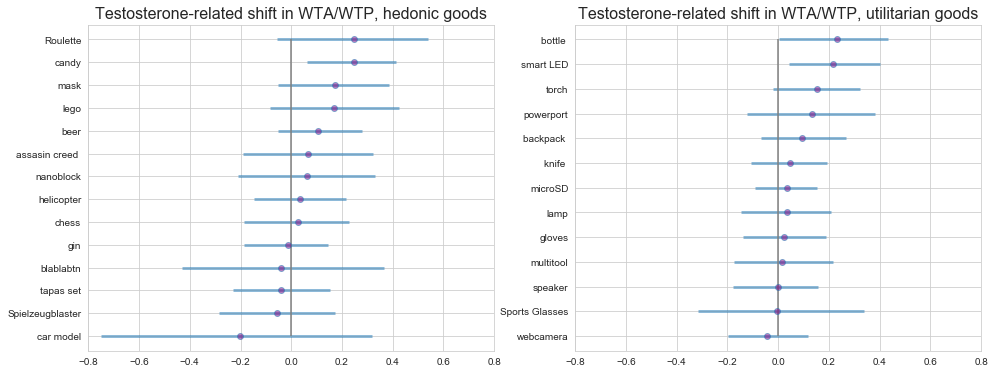

In [18]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
idx = np.argsort(hed.bT)
y_label = hed.loc[idx,'Item']
y_points = np.linspace(0, 1, len(idx))
x = hed.loc[idx,'bT'].values
xerr = np.abs(np.array([hed.loc[idx,'bT_low'].values,hed.loc[idx,'bT_up'].values])-x)
plt.errorbar(x,y_points,xerr = xerr,fmt='C0o', lw=3, alpha=0.5, mfc = 'purple')
plt.yticks(y_points, y_label);
plt.xlim(-0.8,0.8)
plt.vlines(0, 0, 1, 'grey');
plt.title('Testosterone-related shift in WTA/WTP, hedonic goods', size = 16);
plt.subplot(1,2,2)
idx = np.argsort(ut.bT)
y_label = ut.loc[idx,'Item']
y_points = np.linspace(0, 1, len(idx))
x = ut.loc[idx,'bT'].values
xerr = np.abs(np.array([ut.loc[idx,'bT_low'].values,ut.loc[idx,'bT_up'].values])-x)
plt.errorbar(x,y_points,xerr = xerr,fmt='C0o', lw=3, alpha=0.5, mfc = 'purple')
plt.yticks(y_points, y_label);
plt.xlim(-0.8,0.8)
plt.vlines(0, 0, 1, 'grey');
plt.title('Testosterone-related shift in WTA/WTP, utilitarian goods', size = 16);